### set libraly

In [497]:
import pandas as pd
import os
import numpy as np
import glob
import codecs
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style
pd.set_option('display.max_rows', 5000)

### set path

In [469]:
input = "Input\\"
input_data = "Input\\data\\"
input_mapping = "Input\\mapping\\"
output = "Output\\"
backup_data = "Input\\data\\backup_data\\"
output_graph = "Output\\graph\\"
#os.mkdir(input)
#os.mkdir(output)
#os.mkdir(input_data)
#os.mkdir(input_mapping)
#os.mkdir(backup_data)
#os.mkdir(output_graph)

### prepare data

In [3]:
class RawData:
      def __init__(self, folder, folder2):
    
        self.folder = folder
        self.file = glob.glob(folder+"/*.csv")[-1]
        self.folder2 = folder2
        self.file2 = glob.glob(folder+"/*.xlsb")[-1]

    
        print(f"Start to read CSV file '{self.file[-26:]}' in folder '{self.folder}'")
        self.df = pd.read_csv(self.file,encoding='UTF-8' )
        print(f"Read CSV file '{self.file[-22:]}' done!","\n")
        
      def remove_white_space(self):
            print("Start remove_white_space function")
            for col in self.df.columns.tolist():
              if self.df[col].dtypes == object:
                self.df[col] = self.df[col].str.strip()
              print("Remove_white_space done!","\n")
      def save_csv(self):
              self.df.to_csv(input_data+"test.csv",encoding='TIS-620')
              print(f"save file {self.file[-22:]} done" , "\n")

      #def mapping_data(self):
       #       self.df_mapping = pd.read_excel(self.file2,encoding='UTF-8' )
              
    #self.file[-22:]

In [5]:
test = RawData(input_data)
test.remove_white_space()

Start to read CSV file 'Input\data\CRR2563.csv' in folder 'Input\data\'
Read CSV file 'Input\data\CRR2563.csv' done! 

Start remove_white_space function
Remove_white_space done! 

Remove_white_space done! 

Remove_white_space done! 

Remove_white_space done! 

Remove_white_space done! 

Remove_white_space done! 



## mapping_manual

In [207]:
#mapping_2563
mapping = pd.read_excel(input_mapping+'RPISIC01_20201231_ข้อมูลรายตัวสำหรับตรวจสอบ (22 ประเภทธุรกิจ).xlsb',engine='pyxlsb',usecols=['Customer Number','Account Number','USER2','Account Class','PF/NPF Flag'] )
#mapping_2564
mapping2 = pd.read_excel(input_mapping+'RPISIC01_20211231_ข้อมูลรายตัวสำหรับตรวจสอบ (22 ประเภทธุรกิจ).xlsb',engine='pyxlsb',usecols=['Customer Number','Account Number','USER2','Account Class','PF/NPF Flag'] )
#mapping_2565
mapping3 = pd.read_excel(input_mapping+'RPISIC01_20221231_ข้อมูลรายตัวสำหรับตรวจสอบ (22 ประเภทธุรกิจ).xlsb',engine='pyxlsb',usecols=['Customer Number','Account Number','USER2','Account Class','PF/NPF Flag'] )

## Function

In [568]:
#backupdata
def backupdata(df,year):
      print(f"backup data file '{year}' done!","\n")
      return df.to_csv(backup_data+'data'+year+'.csv',encoding='TIS-620',index=False)
      
      
#define good_bad
def define_Good_Bad(df):
    condition = [(df['USER2'] == 'B1')|(df['USER2'] == 'B2'),(df['USER2'] == 'B2')|(df['USER2'] == 'B4')|(df['USER2'] == 'B5')]
    mapping_Good = (1,0)
    mapping_Bad = (0,1)
    df['Good'] = np.select(condition, mapping_Good)
    df['Bad'] = np.select(condition, mapping_Bad)
    return df

#validate
def validate(df):
  table = df[['Grade','Good','Bad']].groupby(['Grade']).sum()
  table.reset_index(inplace=True)
  table.sort_index(ascending=False,inplace=True)
  table['N'] = table['Good'] + table['Bad']
  table['badRate'] = table['Bad'] / table['N']
  table['goodRate'] = table['Good'] / table['N']
  table['%Bad'] = table['Bad'] / table['Bad'].sum()
  table['%Good'] = table['Good'] / table['Good'].sum()
  table['cumBadFreq'] = table['%Bad'].cumsum()
  table['cumGoodFreq'] = table['%Good'].cumsum()
  table['BGOdds'] = table['Bad'].cumsum() / table['Good'].cumsum()
  table['GBOdds'] = table['Good'].cumsum() / table['Bad'].cumsum()
  table['cumBad'] = table['Bad'].cumsum() / table['Bad'].sum()
  table['cumGood'] = table['Good'].cumsum() / table['Good'].sum()
  table['ROC'] = (table['cumGood'] - table['cumGood'].shift(1, fill_value = 0)) * \
                 (table['cumBad'] + table['cumBad'].shift(1, fill_value = 0)) * 0.5
  table['KS'] = abs(table['cumGood'] - table['cumBad']) 
  print(f"validate done!","\n")
  return table

##Plot_KS
def plot_KS(df):
  year = [x for x in globals() if globals()[x] is df][0]  
  #year = year[-4:]  
  KS = df['KS'].max()
  plt.figure(figsize = (10, 6))
  plt.plot(
    np.hstack((0, df['cumGood'])),
    c = 'forestgreen',
    label = 'Cumulative good'
  )
  plt.plot(
    np.hstack((0, df['cumBad'])),
    c = 'gray',
    label = 'Cumulative bad'
    )
  plt.plot([], [], ' ', label = f'KS: {KS * 100:.2f}%')
  plt.xticks(
    np.arange(1, df.shape[0] + 1),
    df['Grade']
  )
  # Fotmat axis label
  ks_max_idx = df['KS'].idxmax()
  ks_N_idx = df.index.max()

  plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
  plt.title('KS Curve_'+year)
  plt.xlabel('Score bands')
  plt.ylabel('Percentage of cumulative')
  plt.legend(frameon = True, facecolor = 'white')
  plt.vlines(ks_N_idx-ks_max_idx+1, ymin = df['cumBad'][ks_max_idx],
             ymax = df['cumGood'][ks_max_idx], color="k", linestyles="--")
  print(f"plot Graph_KS_"+year+" done!","\n")
  #plt.close()
  return plt.gcf()

# Plot
# ROC_GINI
def plot_AUC_GINI(df):
    year = [x for x in globals() if globals()[x] is df][0]  
    AUC = df['ROC'].sum()
    GINI = AUC*2-1
    plt.figure(figsize = (10, 6))
    plt.plot(
        np.hstack((0, df['cumGood'])),
        np.hstack((0, df['cumBad'])),
        c = 'forestgreen',
        label = 'ROC Curve'
    )
    plt.plot(
        [0, 1],
        [0, 1],
        c = 'gray',
        linestyle = '--',
        label = 'Random curve'
    )
    plt.plot([], [], ' ', label = f'AUC: {AUC * 100:.2f}%, GINI: {GINI * 100:.2f}%')
    # Fotmat axis label
    plt.gca().set_xticklabels([f'{x * 100:.2f}%' for x in plt.gca().get_xticks()])
    plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
    plt.title('ROC Curve_'+year)
    plt.xlabel('Percentage of good')
    plt.ylabel('Percentage of bad')
    plt.legend(frameon = True, facecolor = 'white')
    print(f"plot Graph_AUC_GINI_"+year+" done!","\n")
    #plt.close()
    return plt.gcf()

##export graph to jpg
def export_Graph(graph):
    fname = [x for x in globals() if globals()[x] is graph][0]  
    graph.savefig(output_graph+fname+'.jpg') 
    print(f"export Graph done!","\n")

### Preparedata_Grade (delete number)
def grade_Fix(df):
    condition = [(df['Grade'] == '1.AAA')|(df['Grade'] == 'AAA'),(df['Grade'] == '2.AA')|(df['Grade'] == 'AA'),(df['Grade'] == '3.A+')|(df['Grade'] == 'A+'),(df['Grade'] == '4.BBB')|(df['Grade'] == 'BBB'),(df['Grade'] == '5.BB')|(df['Grade'] == 'BB'),
                 (df['Grade'] == '6.B+')|(df['Grade'] == 'B+'),(df['Grade'] == '7.CCC')|(df['Grade'] == 'CCC'),(df['Grade'] == '8.CC')|(df['Grade'] == 'CC'),(df['Grade'] == '9.C+')|(df['Grade'] == 'C+'),(df['Grade'] == '10.DDD')|(df['Grade'] == 'DDD'),
                 (df['Grade'] == '11.DD')|(df['Grade'] == 'DD'),(df['Grade'] == '12.D+')|(df['Grade'] == 'D+'),(df['Grade'] == '13.sAAA')|(df['Grade'] == 'sAAA'),(df['Grade'] == '14.sAA')|(df['Grade'] == 'sAA'),(df['Grade'] == '15.sA+')|(df['Grade'] == 'sA+'),
                 (df['Grade'] == '16.sBBB')|(df['Grade'] == 'sBBB'),(df['Grade'] == '17.sBB')|(df['Grade'] == 'sBB'),(df['Grade'] == '18.sB+')|(df['Grade'] == 'sB+'),(df['Grade'] == '19.sCCC')|(df['Grade'] == 'sCCC'),(df['Grade'] == '20.sCC')|(df['Grade'] == 'sCC'),
                 (df['Grade'] == '21.sC+')|(df['Grade'] == 'sC+'),(df['Grade'] == '22.sDDD')|(df['Grade'] == 'sDDD'),(df['Grade'] == '23.sDD')|(df['Grade'] == 'sDD'),(df['Grade'] == '24.sD+')|(df['Grade'] == 'sD+')]
    mapping_Grade = ('AAA','AA','A+','BBB','BB','B+','CCC','CC','C+','DDD','DD','D+','sAAA','sAA','sA+','sBBB','sBB','sB+','sCCC','sCC','sC+','sDDD','sDD','sD+')
    df['Grade'] = np.select(condition, mapping_Grade)

## prepare_data_2563 

In [208]:
### prepare 
data = pd.read_csv(input_data+'CRR2563.csv',encoding='UTF-8')
data['เลขที่ CIF'] = data['เลขที่ CIF'].str.strip()
data.dropna(subset=['เลขที่ CIF'],inplace=True)
data.rename(columns={"เลขที่ CIF": "Customer Number"},inplace=True)
### fitter not number
data_main = data[data['Customer Number'].str.contains(r'[0-9]')]
### convert type object to int
data_main['Customer Number'] = data_main['Customer Number'].astype(np.int64)
### map data
df = data_main.merge(mapping,on='Customer Number',how='left')
df = df.dropna(subset=['USER2'])
df = df.drop_duplicates(subset=['Customer Number'])
df = df.dropna(subset=['Grade'])
df = df[~(df['Grade']=='-')]
df.reset_index(drop=True)
### Define Good_Bad
df_2563 = define_Good_Bad(df)
### backup_data
backupdata(df_2563,'2563')
### Medium && Large CRR
df_2563['Grade'].isna().value_counts()
df_2563.groupby(['Grade']).count()
df_CRR_2563 = df_2563[~df_2563['Grade'].str.contains('[s,S]')]
df_CRR_2563[['Grade','Good','Bad']].groupby(['Grade']).sum()
### Small CRR
df_sCRR_2563 = df_2563[df_2563['Grade'].str.contains('[s,S]')]
df_sCRR_2563.loc[df_sCRR_2563['Grade']=='SBB','Grade'] = 'sBB'
df_sCRR_2563.loc[df_sCRR_2563['Grade']=='sc+','Grade'] = 'sC+'
df_sCRR_2563 = df_sCRR_2563[~(df_sCRR_2563['Grade']=='SS')]
df_sCRR_2563[['Grade','Good','Bad']].groupby(['Grade']).sum()

## prepare_data_2564 

In [589]:
### prepare 
data = pd.read_csv(input_data+'CRR2564.csv',encoding='UTF-8')
data['เลขที่ CIF'] = data['เลขที่ CIF'].str.strip()
data.dropna(subset=['เลขที่ CIF'],inplace=True)
data.rename(columns={"เลขที่ CIF": "Customer Number"},inplace=True)
### fitter not number
data_main = data[data['Customer Number'].str.contains(r'[0-9]')]
data_main = data_main[data_main['Customer Number'] != 'G514300']
### convert type object to int
data_main['Customer Number'] = data_main['Customer Number'].astype(np.int64)
df = data_main.merge(mapping,on='Customer Number',how='left')
df = df.dropna(subset=['USER2'])
df = df.drop_duplicates(subset=['Customer Number'])
df = df.dropna(subset=['Grade'])
df = df[~(df['Grade']=='-')]
df.reset_index(drop=True)
### map data
df = data_main.merge(mapping,on='Customer Number',how='left')
df = df.dropna(subset=['USER2'])
df = df.drop_duplicates(subset=['Customer Number'])
df = df.dropna(subset=['Grade'])
df = df[~(df['Grade']=='-')]
df.reset_index(drop=True)
### Preparedata_Grade
#df['Grade'].unique()
grade_Fix(df)
#df.groupby(['Grade']).sum()
### Define Good_Bad
df_2564 = define_Good_Bad(df)
### backup_data
backupdata(df_2564,'2564')
### Medium && Large CRR
df_CRR_2564 = df_2564[~df_2564['Grade'].str.contains('[s,S]')]
df_CRR_2564[['Grade','Good','Bad']].groupby(['Grade']).sum()
### Small CRR
df_sCRR_2564 = df_2564[df_2564['Grade'].str.contains('[s,S]')]
df_sCRR_2564[['Grade','Good','Bad']].groupby(['Grade']).sum()

backup data file '2564' done! 



,Good,Bad
Grade,,
sA+,16,0
sB+,67,0
sBB,83,0
sBBB,56,0
sC+,27,1
sCC,46,0
sCCC,37,0
sDD,1,1
sDDD,12,0


## prepare_data_2565 

## plot graph

validate done! 

plot Graph_KS_CRR_2563 done! 

export Graph done! 

plot Graph_AUC_GINI_CRR_2563 done! 

export Graph done! 

validate done! 

plot Graph_KS_sCRR_2563 done! 

export Graph done! 

plot Graph_AUC_GINI_sCRR_2563 done! 

export Graph done! 

validate done! 

plot Graph_KS_CRR_2564 done! 

export Graph done! 

plot Graph_AUC_GINI_CRR_2564 done! 

export Graph done! 

validate done! 

plot Graph_KS_sCRR_2564 done! 

export Graph done! 

plot Graph_AUC_GINI_sCRR_2564 done! 

export Graph done! 



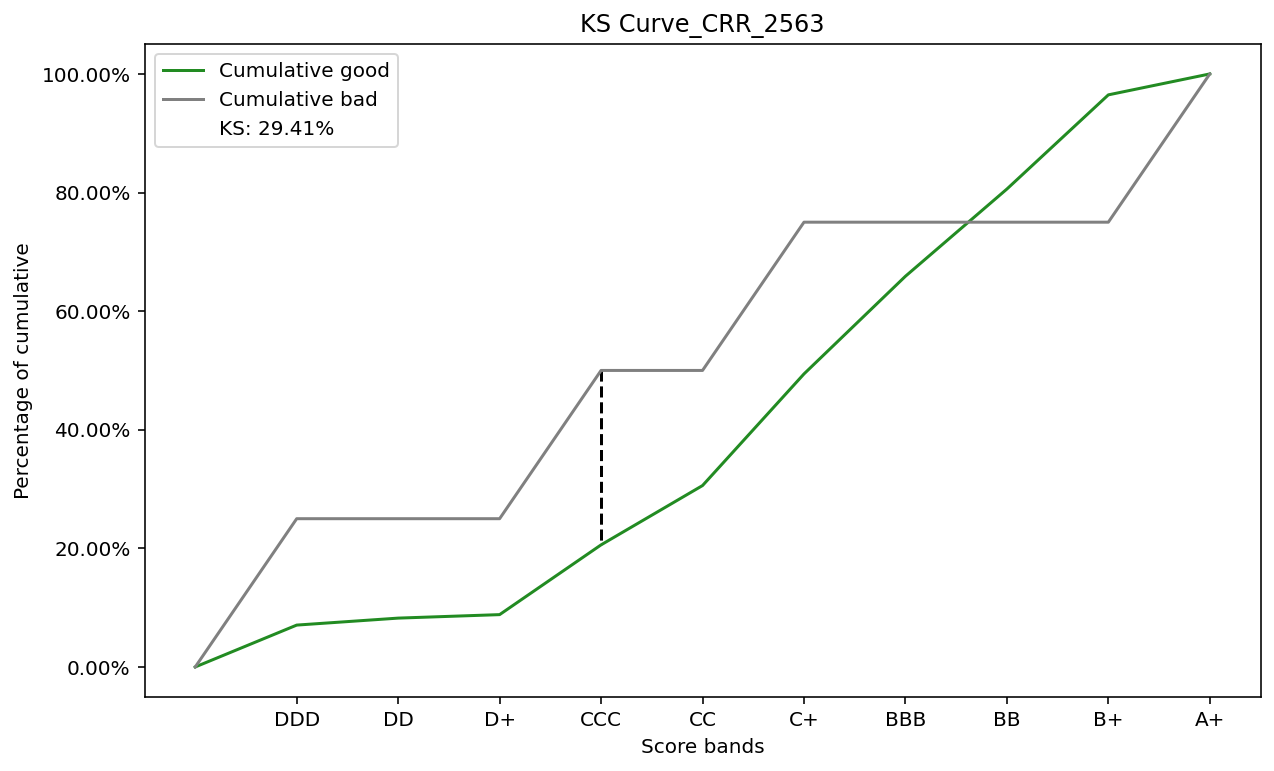

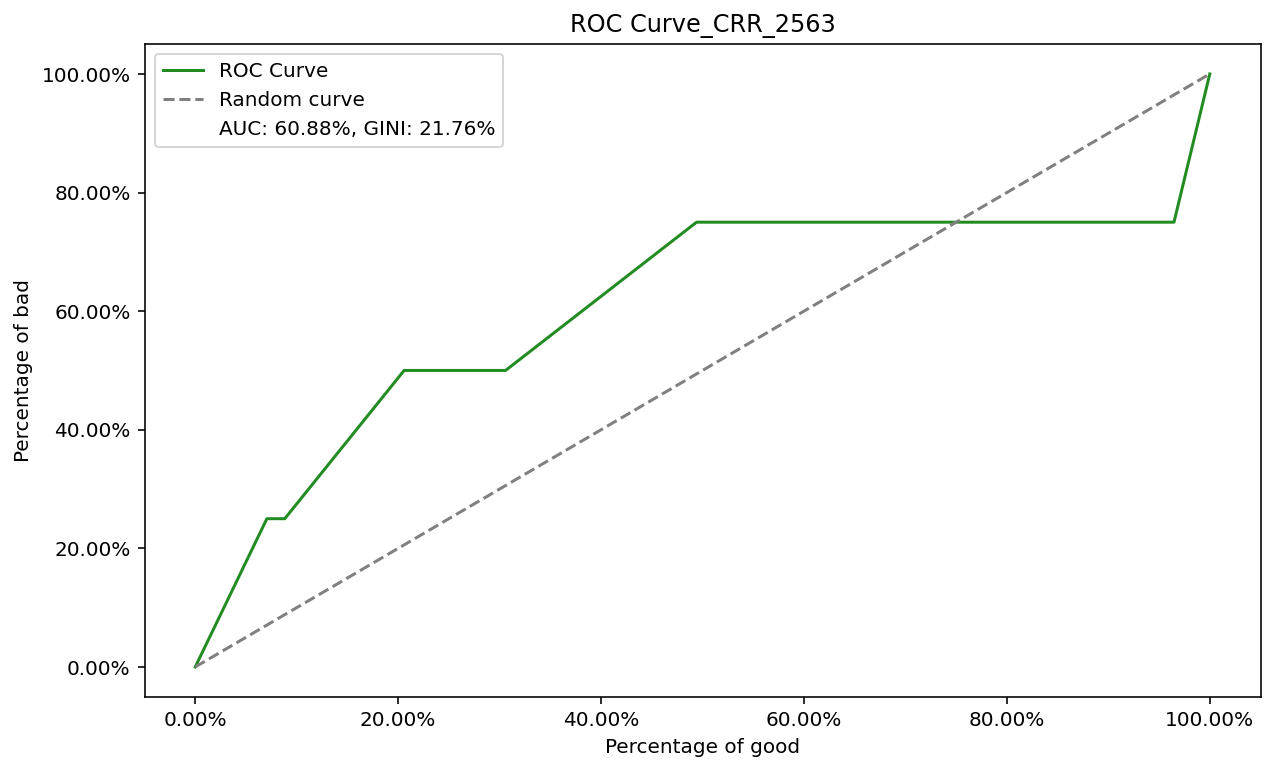

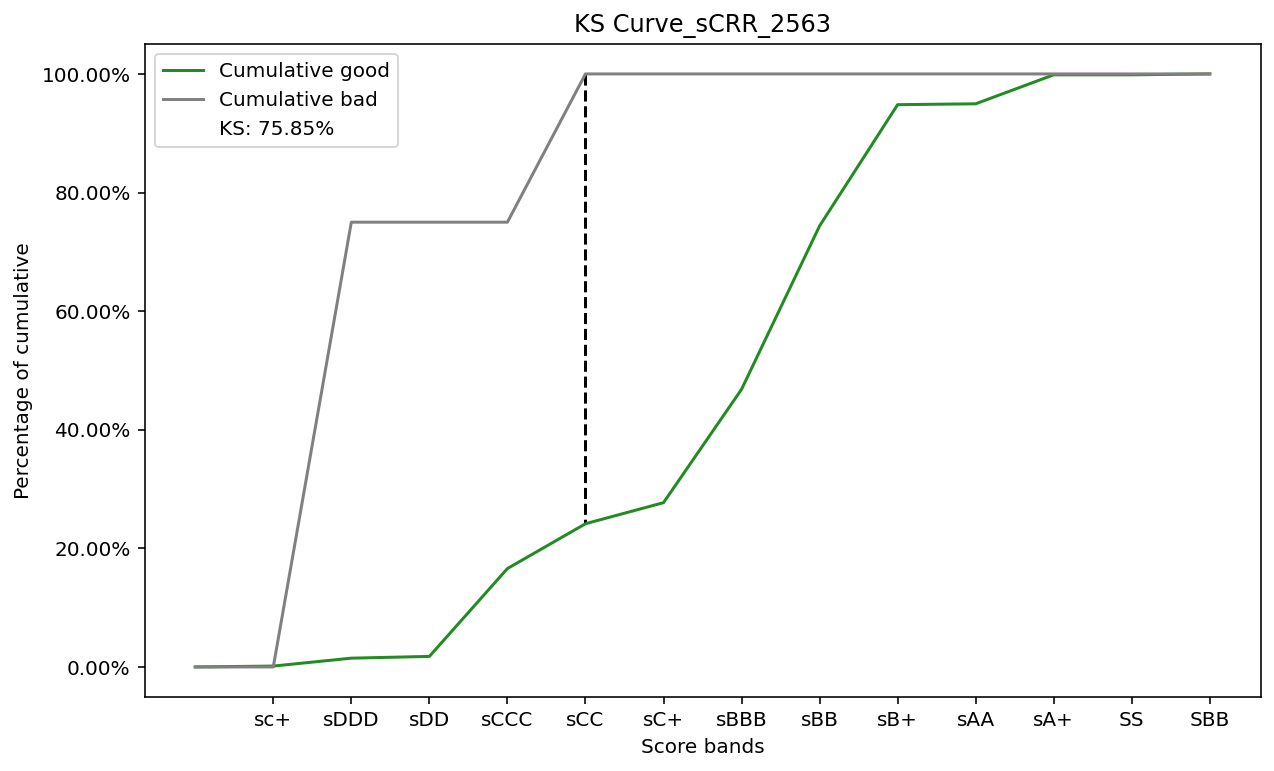

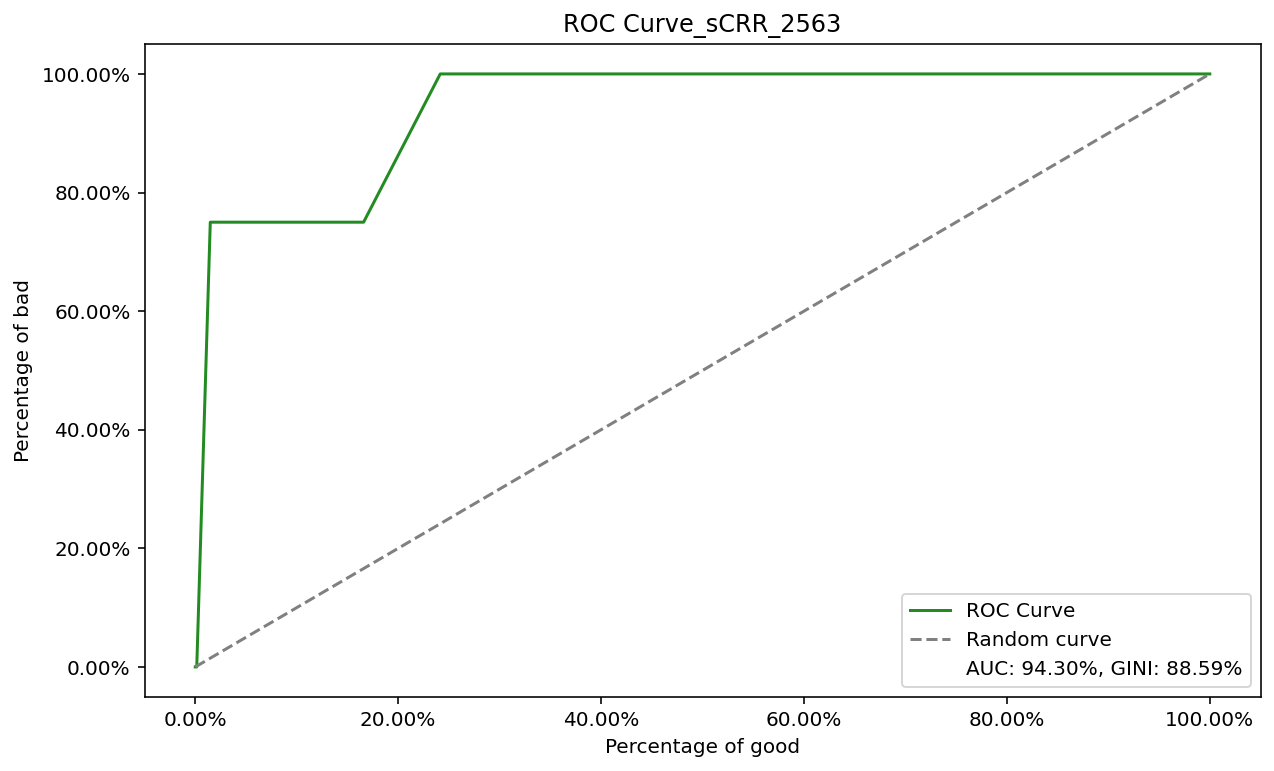

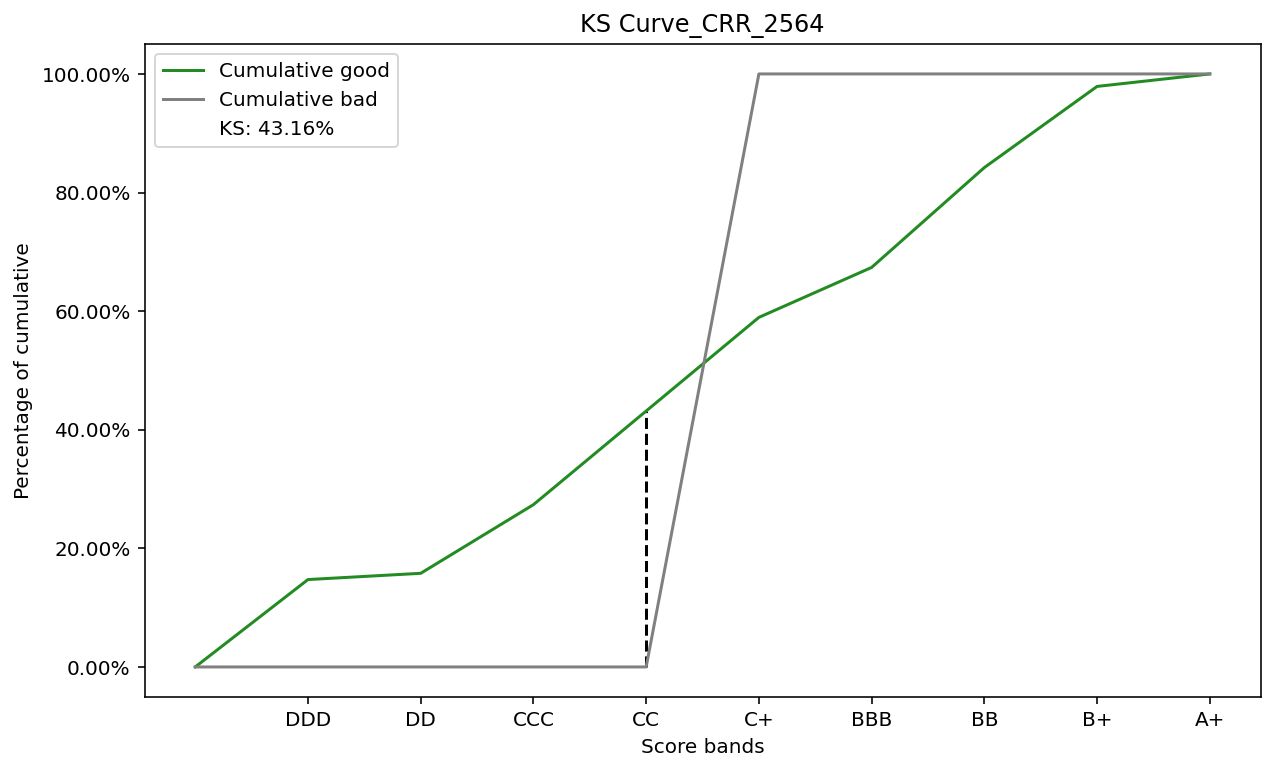

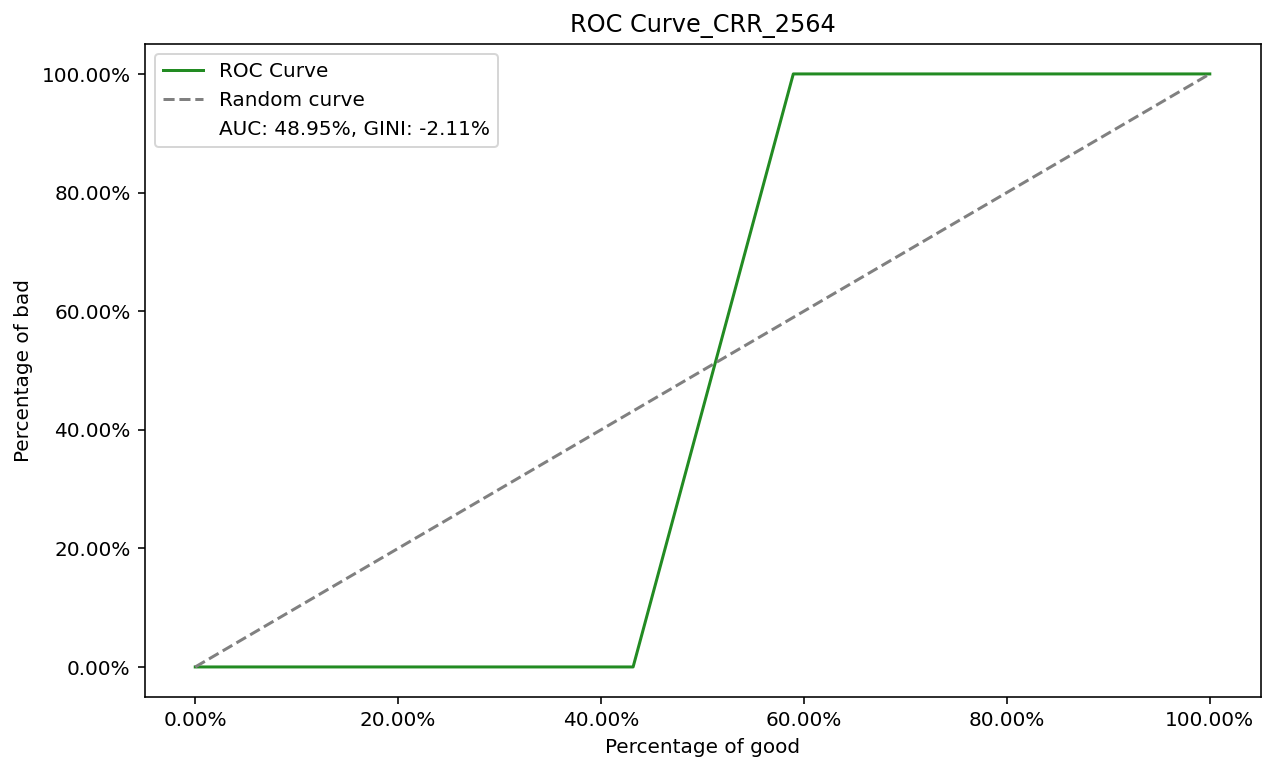

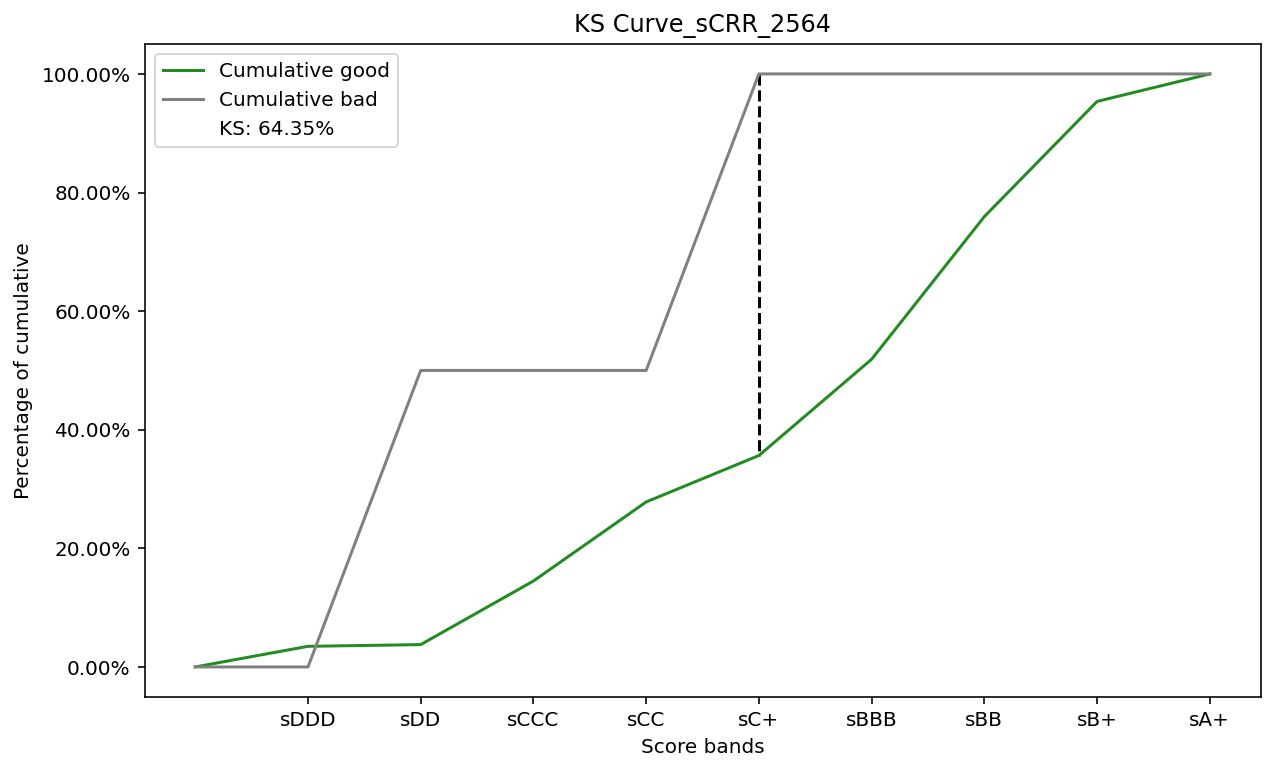

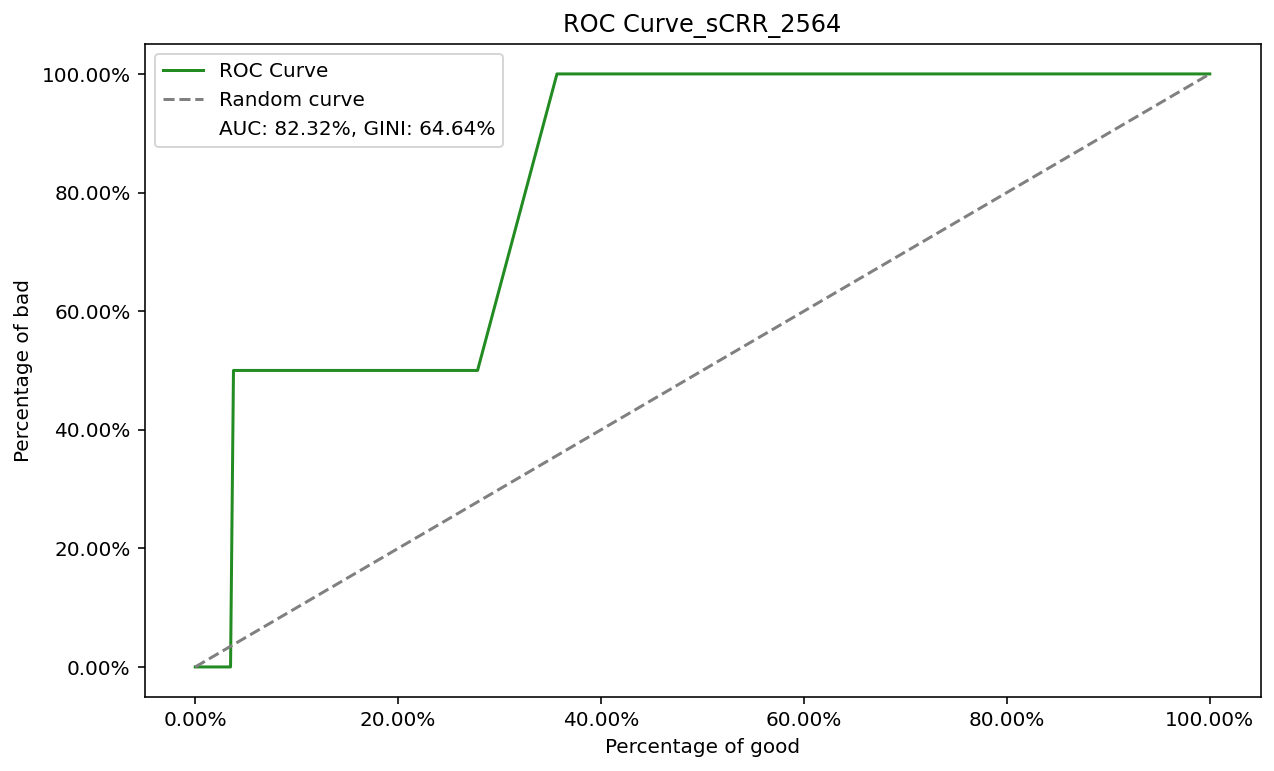

In [591]:
##As_of_2563
##CRR
CRR_2563 =  validate(df_CRR_2563)
KS_CRR_2563 = plot_KS(CRR_2563)
export_Graph(KS_CRR_2563)
AUC_GINI_CRR_2563 = plot_AUC_GINI(CRR_2563)
export_Graph(AUC_GINI_CRR_2563)
##sCRR
sCRR_2563 =  validate(df_sCRR_2563)
KS_sCRR_2563 = plot_KS(sCRR_2563)
export_Graph(KS_sCRR_2563)
AUC_GINI_sCRR_2563 = plot_AUC_GINI(sCRR_2563)
export_Graph(AUC_GINI_sCRR_2563)
##As_of_2564
CRR_2564 =  validate(df_CRR_2564)
KS_CRR_2564 = plot_KS(CRR_2564)
export_Graph(KS_CRR_2564)
AUC_GINI_CRR_2564 = plot_AUC_GINI(CRR_2564)
export_Graph(AUC_GINI_CRR_2564)
##sCRR
sCRR_2564 =  validate(df_sCRR_2564)
KS_sCRR_2564 = plot_KS(sCRR_2564)
export_Graph(KS_sCRR_2564)
AUC_GINI_sCRR_2564 = plot_AUC_GINI(sCRR_2564)
export_Graph(AUC_GINI_sCRR_2564)